In [1]:
from datetime import date
from enum import Enum

%load_ext google.cloud.bigquery
from google.cloud import bigquery

import pandas as pd

In [2]:
project = "celo-testnet"
client = bigquery.Client(project)
for dataset in client.list_datasets():
    print(dataset.dataset_id)

dataflow_metrics
load_test_data
segment_data
segment_data_events
segment_data_metrics
tme_test_stakeoff
transaction_data
transaction_metrics_exporter


In [3]:
partition = date.today().strftime("%Y%m%d")
# partition = 20200316
# partition = "*"
dataset = "transaction_metrics_exporter"
table = "transaction_metrics_exporter_{0}".format(partition)
tme = client.get_dataset(dataset)
table_path = ".".join([project, dataset, table])
table_path = "celo-testnet.tme_test_stakeoff.tme_stakeoff_test_20200323"
print(table_path)

celo-testnet.tme_test_stakeoff.tme_stakeoff_test_20200323


In [4]:
class EventTypes(Enum):
    RECEIVED_BLOCK="RECEIVED_BLOCK"
    RECEIVED_STATE="RECEIVED_STATE"
    RECEIVED_TRANSACTION="RECEIVED_TRANSACTION"
    RECEIVED_TRANSACTION_RECEIPT="RECEIVED_TRANSACTION_RECEIPT"
    RECEIVED_PARSED_TRANSACTION="RECEIVED_PARSED_TRANSACTION"
    RECEIVED_PARSED_LOG="RECEIVED_PARSED_LOG"

In [5]:
query_blocks = f"""
SELECT 
  MAX(T.jsonPayload.timestamp) as timestamp,
  T.jsonPayload.number as blockNumber,
  MAX(T.jsonPayload.gasUsed) as gasUsed,
  MAX(T.jsonPayload.gasLimit) as gasLimit,
  COUNT(T.jsonPayload.transactions) as txAmount
FROM 
  `{table_path}` as T
WHERE
   T.jsonPayload.event='{EventTypes.RECEIVED_BLOCK.value}'
GROUP BY blockNumber
ORDER BY blockNumber DESC 
"""

df_blocks = client.query(
    query_blocks, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_blocks.describe()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount
count,9.382000e+03,9382.000000,9.382000e+03,9382.0,9382.000000
mean,1.578769e+09,14596.144319,1.189959e+04,20000000.0,1.065125
std,1.436620e+04,2867.666777,1.546723e+05,0.0,0.917862
min,1.578698e+09,500.000000,0.000000e+00,20000000.0,1.000000
25%,1.578758e+09,12298.250000,0.000000e+00,20000000.0,1.000000
50%,1.578770e+09,14643.500000,0.000000e+00,20000000.0,1.000000
75%,1.578781e+09,16988.750000,0.000000e+00,20000000.0,1.000000
max,1.578793e+09,19334.000000,1.095853e+07,20000000.0,14.000000


In [6]:
df_blocks.head()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount
0,1.578793e+09,19334.0,0.0,20000000.0,1
1,1.578793e+09,19333.0,0.0,20000000.0,1
2,1.578793e+09,19332.0,0.0,20000000.0,1
3,1.578793e+09,19331.0,0.0,20000000.0,1
4,1.578793e+09,19330.0,0.0,20000000.0,1


last block  : 19334 on 1578793117.0
first block : 500 on 1578697906.0
blocks load : 9382
transactions: 9993
mean gasUsed: 11900 GcWei


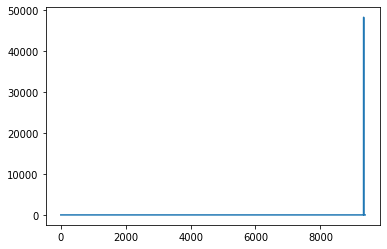

In [7]:
last_block, first_block = df_blocks.blockNumber.max(), df_blocks.blockNumber.min()
print(f"last block  : {last_block:.0f} on {df_blocks.timestamp.max()}") 
print(f"first block : {first_block:.0f} on {df_blocks.timestamp.min()}")
print(f"blocks load : {df_blocks.timestamp.count():.0f}")
print(f"transactions: {df_blocks.txAmount.sum()}")
print(f"mean gasUsed: {df_blocks.gasUsed.mean():.0f} GcWei")
df_blocks[::-1].diff(axis=0).timestamp.plot()

In [30]:
query_state = f"""
SELECT
  timestamp,
  jsonPayload.blockNumber,
  jsonPayload.values.rewardsamount,
  jsonPayload.values.rewardsmultiplier,
  jsonPayload.values.medianRate,
  jsonPayload.values.currentStableBucket,
  jsonPayload.values.currentGoldBucket,
  jsonPayload.values.goldTokenTotalSupply
FROM 
  `{table_path}` as T
WHERE 
  jsonPayload.event='{EventTypes.RECEIVED_STATE.value}'
ORDER BY 
  T.jsonPayload.blockNumber DESC,
  T.timestamp DESC
"""

df_state = client.query(
    query_state, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_state.describe()

,blockNumber,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply
count,53295.000000,1.065900e+04,1.065900e+04,10659.0,1.065900e+04,1.065900e+04,1.065900e+04
mean,14106.307721,6.000292e+26,1.616452e+24,10.0,9.995616e+24,9.995616e+23,1.069011e+26
std,4467.678142,9.527368e+21,2.641005e+19,0.0,1.350670e+21,1.350670e+20,1.718068e+10
min,500.000000,6.000000e+26,1.616372e+24,10.0,9.995200e+24,9.995200e+23,1.069011e+26
25%,12006.000000,6.000248e+26,1.616440e+24,10.0,9.995200e+24,9.995200e+23,1.069011e+26
50%,14671.000000,6.000304e+26,1.616456e+24,10.0,9.995200e+24,9.995200e+23,1.069011e+26
75%,17336.000000,6.000360e+26,1.616471e+24,10.0,9.995200e+24,9.995200e+23,1.069011e+26
max,20000.000000,6.000417e+26,1.616487e+24,10.0,1.000000e+25,1.000000e+24,1.069011e+26


In [31]:
df = df_state \
    .groupby('blockNumber').max() \
    .merge(df_blocks, left_on='blockNumber', right_on='blockNumber', suffixes=('_tme', '_block'))
df['datetime_block'] = pd.to_datetime(df['timestamp_block'],unit='s')
df.head()

,blockNumber,timestamp_tme,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,datetime_block
0,500.0,2020-03-23 12:49:44.898715+00:00,6.000000e+26,1.616372e+24,10.0,1.000000e+25,1.000000e+24,1.069011e+26,1.578698e+09,27023.0,20000000.0,14,2020-01-10 23:11:46
1,501.0,2020-03-23 12:49:45.993999+00:00,6.000000e+26,1.616372e+24,10.0,1.000000e+25,1.000000e+24,1.069011e+26,1.578698e+09,658641.0,20000000.0,14,2020-01-10 23:11:51
2,502.0,2020-03-23 12:49:46.593390+00:00,6.000000e+26,1.616372e+24,10.0,1.000000e+25,1.000000e+24,1.069011e+26,1.578698e+09,6628959.0,20000000.0,14,2020-01-10 23:11:56
3,503.0,2020-03-23 12:49:47.039711+00:00,6.000000e+26,1.616372e+24,10.0,1.000000e+25,1.000000e+24,1.069011e+26,1.578698e+09,29625.0,20000000.0,14,2020-01-10 23:12:01
4,504.0,2020-03-23 12:49:47.495530+00:00,6.000000e+26,1.616372e+24,10.0,1.000000e+25,1.000000e+24,1.069011e+26,1.578698e+09,166350.0,20000000.0,14,2020-01-10 23:12:06


Text(0, 0.5, 'SortedOracles.medianRate')

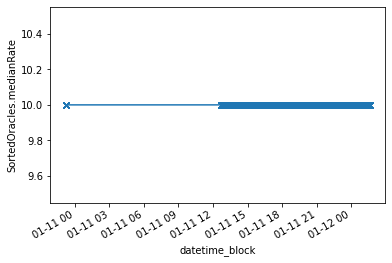

In [32]:
df_sortedOracles = df.set_index('datetime_block')['medianRate']
ax = df_sortedOracles.plot(marker="x")
ax.set_ylabel("SortedOracles.medianRate")

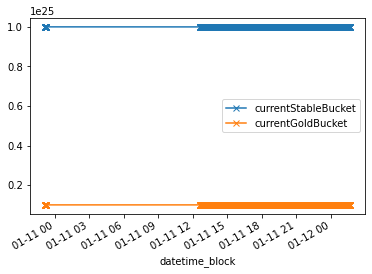

In [33]:
df_stableToken = df.set_index('datetime_block')[['currentStableBucket', 'currentGoldBucket']].astype('float')
df_stableToken.plot(marker="x")

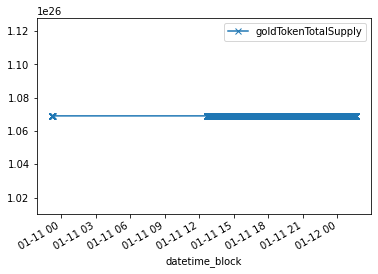

In [34]:
df_goldToken = df.set_index('datetime_block')[['goldTokenTotalSupply']]
ax = df_goldToken.plot(marker="x")

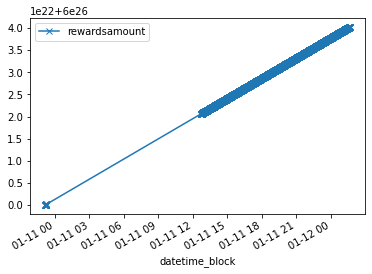

In [35]:
df_rewardsAmount = df.set_index('datetime_block')[['rewardsamount']]
ax = df_rewardsAmount.plot(marker="x")

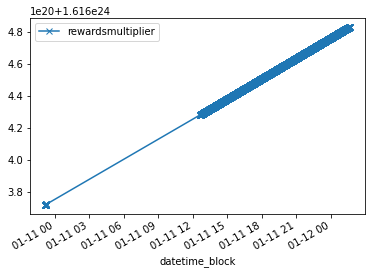

In [36]:
df_rewardsMultiplier = df.set_index('datetime_block')[['rewardsmultiplier']]
ax = df_rewardsMultiplier.plot(marker="x")

In [21]:
df_rewardsAmount

,rewardsamount
datetime_block,
2020-01-12 01:38:37,6.000403e+26
2020-01-12 01:38:32,6.000403e+26
2020-01-12 01:38:27,6.000403e+26
2020-01-12 01:38:22,6.000403e+26
2020-01-12 01:38:17,6.000403e+26
...,...
2020-01-10 23:11:46,6.000000e+26
2020-01-10 23:11:46,6.000000e+26
2020-01-10 23:11:46,6.000000e+26
